## Will this person subscribe to a car insurance ?
The aim of this project is to be able to predict and to explain why a person would subscribe to a car insurance. To perform this task, we gathered data which is thousands of Cold Calls that occured two years ago. We gathered data from $\href{https://www.kaggle.com/kondla/carinsurance?select=carInsurance_train.csv}{Kaggle}$ which explains each variable in detail.
First, let us import all packages that we will need during this notebook.

In [56]:
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc

sns.set() # Allows to affect Seaborn style to Matplotlib

## Context
Our dataset contains multiple categorical and numerical explainatory variables that will help us to predict if a customer would subscribe to a car insurance ( 1
  for "yes" and  0
  for "no"). Predicting if a customer would likely subscribe a car insurance is not only useful to sales' predictions, but in can in fact improve different processes :
- First, remind that calling people needs time, so if a customer is predicted to not subscribing to a car insurance with a strong confidence, we know that phone calls are not effective ways to convince him.
- Moreover, it can also helps to clusters group of people and to detect exhibit types of customers.
- Finally, usage of such techniques could be suitable to propose customized contracts.



In [57]:
models = dict({})

In [58]:
# Ready-to-use method to plot ROC curves.
def plot_roc(model, create_figure=False):
    if create_figure:
        plt.figure(figsize=(10, 6))
    fpr, tpr, _ = roc_curve(Y_test.values, model.predict_proba(X_test)[:,1])
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) curve')
    plt.legend(loc="lower right")
    plt.show()

In [59]:
# Computed our 3 metrics on a model with test set.
def compute_metrics(model, x_test=None, y_test=None, verbose=True):
    """
    Computes 3 accuracy metrics.
    model : Model to compute metrics with.
    x_test : Custom test set.
    y_test : Custom ground truth values.
    """
    if x_test is None and y_test is None:
        x_test = X_test
        y_test = Y_test
    Y_pred = model.predict(x_test)
    fpr, tpr, _ = roc_curve(y_test.values, model.predict_proba(x_test)[:,1])
    dict_out = {
        'Accuracy': accuracy_score(y_test, Y_pred),
        'F1 Score': f1_score(y_test, Y_pred),
        'AUC': auc(fpr, tpr)
    }
    if verbose:
        print("Metrics :", dict_out)
    return dict_out

In [60]:
# This method will be helpful when we will use grid tuning to select best hyper-parameters of our models
def grid_tuning(instance, grid):
    cv = GridSearchCV(instance, grid, n_jobs=1, refit=True, scoring='roc_auc',
                   verbose=0, cv=5, return_train_score=True)
    cv.fit(X_train, Y_train)
    print("Best parameters :", cv.best_params_)
    return cv

### Data querying and exploration
In this part we perform data querying, which is easily done thanks to pandas package.

In [61]:
import pandas as pd

dataset = pd.read_csv("carInsurance.csv")

In [62]:
dataset.shape

(4000, 19)

We have  4000 observations in our dataset with  19 variables.

In [63]:
dataset.head()

,Id,Age,Job,Marital,Education,Default,Balance,HHInsurance,CarLoan,Communication,LastContactDay,LastContactMonth,NoOfContacts,DaysPassed,PrevAttempts,Outcome,CallStart,CallEnd,CarInsurance
0,1,32,management,single,tertiary,0,1218,1,0,telephone,28,jan,2,-1,0,NaN,13:45:20,13:46:30,0
1,2,32,blue-collar,married,primary,0,1156,1,0,NaN,26,may,5,-1,0,NaN,14:49:03,14:52:08,0
2,3,29,management,single,tertiary,0,637,1,0,cellular,3,jun,1,119,1,failure,16:30:24,16:36:04,1
3,4,25,student,single,primary,0,373,1,0,cellular,11,may,2,-1,0,NaN,12:06:43,12:20:22,1
4,5,30,management,married,tertiary,0,2694,0,0,cellular,3,jun,1,-1,0,NaN,14:35:44,14:38:56,0


Now we print columns' names to globally see different types of variables. Note that each variable is explained in the documentation on data's repository.

In [64]:
features = np.asarray(dataset.columns)
features



array(['Id', 'Age', 'Job', 'Marital', 'Education', 'Default', 'Balance',
       'HHInsurance', 'CarLoan', 'Communication', 'LastContactDay',
       'LastContactMonth', 'NoOfContacts', 'DaysPassed', 'PrevAttempts',
       'Outcome', 'CallStart', 'CallEnd', 'CarInsurance'], dtype=object)

### Data processing
In this section, we present how we gather dataset into a pandas DataFrame thanks to reading pipelines.
 
#### Feature engineering
First, we have to convert categorical variables to numerical variables. For example, Job, Marital and Education are categorical variables that need to be encoded. For this kind of variable, a powerful but simply method is label encoding : each output is labelled to an index, and feature's value is now corresponding index. Not that we could also have used one-hot encoding, but since we have a few outputs, label encoding is the most suitable.

Moreover, since we want to be time-independent, we should take call duration instead of call end and call start, as we assume that time has no impact on outcome.

In [65]:
from datetime import datetime
from sklearn.preprocessing import LabelEncoder

def preprocess(dataset):
    X = pd.DataFrame()
    numerical_features = [ "Age", "Balance", "HHInsurance", "LastContactDay", "NoOfContacts", "CarLoan", "PrevAttempts" ]
    X[numerical_features] = dataset[numerical_features]
    call_starts = dataset["CallStart"].apply(lambda x: datetime.strptime(x, '%H:%M:%S'))
    call_ends = dataset["CallEnd"].apply(lambda x: datetime.strptime(x, '%H:%M:%S'))
    # We obtain CallDuration from both previous features, as it is time-independent
    X["CallDuration"] = (call_ends - call_starts).apply(lambda x: x.seconds)
    Y = dataset["CarInsurance"]
    
    # Removing NA tha tcreates instability
    dataset["Job"].fillna("na", inplace=True)
    dataset["Marital"].fillna("na", inplace=True)
    dataset["Education"].fillna("na", inplace=True)
    
    # Label encoding for categorical variables
    label_encoder = LabelEncoder()
    X["Job"] = label_encoder.fit_transform(dataset["Job"])
    X["Marital"] = label_encoder.fit_transform(dataset["Marital"])
    X["Education"] = label_encoder.fit_transform(dataset["Education"])
    return X, Y

Finally, we split our dataset into a train set and a test set. Parameter test_size specify that  10%
  of dataset will be on test set, hence test set has  400
  rows.

In [66]:
processed_dataset = preprocess(dataset)
X_train, X_test, Y_train, Y_test = train_test_split(*processed_dataset, test_size=0.1, shuffle=True)

### Statistical models
In the next cells, we will focus on statistical models that are described in the Actuary Report. For each model, we follow a special pipeline :
- First, we train our model with "dummy" hyper-parameters.
- Then, thanks to previously coded grid-tuning cross validation, we select best hypyer-parameters.
- Finally, we retrain our model with optimized hyper-parameters and log metrics to dictionary.

##  Gradient Boosting model

In [67]:
#pip install xgboost

In [68]:
import xgboost as xgb

from sklearn.metrics import roc_curve, auc

In [69]:
param = {'max_depth':3, 'eta':1., 'silent':1, 'objective':'binary:logistic', 'n_estimators': 300, 'iter': 100 }
booster = xgb.XGBClassifier(**param)
booster.fit(X_train, Y_train)

[17:03:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=1.0, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              iter=100, learning_rate=1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, silent=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [70]:
models['Gradient Boosting'] = compute_metrics(booster)
models['Gradient Boosting']

Metrics : {'Accuracy': 0.7925, 'F1 Score': 0.7313915857605178, 'AUC': 0.8617886178861789}


{'Accuracy': 0.7925, 'F1 Score': 0.7313915857605178, 'AUC': 0.8617886178861789}

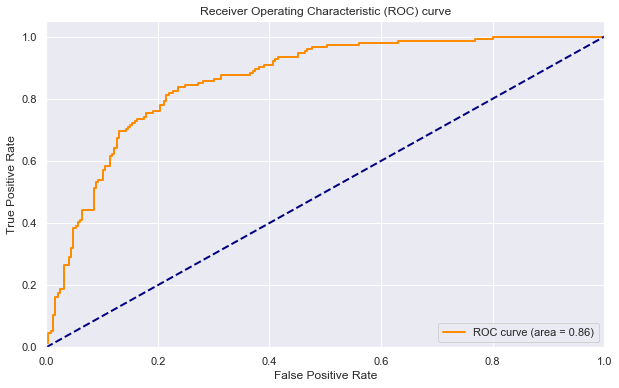

In [71]:
plot_roc(booster, create_figure=True)

### Tuning of Gradient Boosting model


In [72]:
cv = grid_tuning(xgb.XGBClassifier(),
            { 'max_depth': [2, 3, 4] , 'learning_rate': [0.001, 0.01, 0.1, 1], 'n_estimators': [300] })
optim_param = dict({'silent':1, 'objective':'binary:logistic', 'iter': 100 }, **cv.best_params_)
booster = xgb.XGBClassifier(**optim_param)
booster.fit(X_train, Y_train)
models['Gradient Boosting'] = compute_metrics(booster)
del cv

Best parameters : {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 300}
[17:04:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Metrics : {'Accuracy': 0.8, 'F1 Score': 0.7468354430379747, 'AUC': 0.8732182451694647}


### Random Forest model
The implementation of Breiman'sRandom Forest (2001) grow $M$ independent trees $f_1, .., f_M$ that are averaged together to reduce variance :
$$ f(\mathbf{X}) =\frac{1}{M} \sum_{i=1}^{M}f_i(\mathbf{X})
$$
Experiments have shown that Random Forest are as powerful as boosting-based models such as Gradient Boosting on real-world data.

In [73]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()
random_forest.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [74]:
models['Random Forest'] = compute_metrics(random_forest)
models['Random Forest']

Metrics : {'Accuracy': 0.75, 'F1 Score': 0.6644295302013423, 'AUC': 0.8333993242529829}


{'Accuracy': 0.75, 'F1 Score': 0.6644295302013423, 'AUC': 0.8333993242529829}

In [75]:
cv = grid_tuning(RandomForestClassifier(),
            { 'n_estimators': [100, 300, 500], 'min_samples_leaf': [ 1, 3, 5 ]  })
random_forest = RandomForestClassifier(**cv.best_params_)
random_forest.fit(X_train, Y_train)
models['Random Forest'] = compute_metrics(random_forest)
del cv

Best parameters : {'min_samples_leaf': 5, 'n_estimators': 100}
Metrics : {'Accuracy': 0.795, 'F1 Score': 0.7371794871794872, 'AUC': 0.8694699609333756}


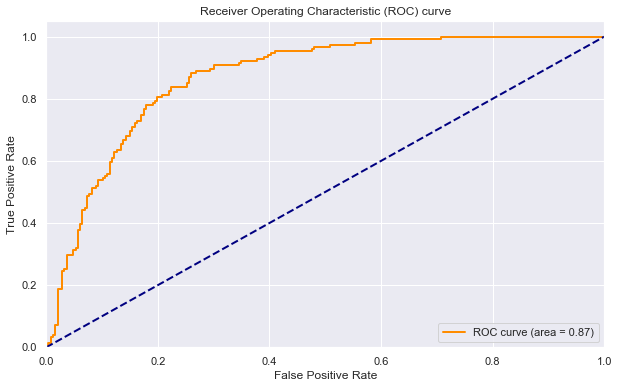

In [76]:
plot_roc(random_forest, create_figure=True)

### Extremely Randomized Trees

In [77]:
from sklearn.ensemble import ExtraTreesClassifier

extra_trees = ExtraTreesClassifier()
extra_trees.fit(X_train, Y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [78]:
cv = grid_tuning(ExtraTreesClassifier(),
            { 'n_estimators': [100, 300, 500], 'min_samples_leaf': [ 1, 3, 5 ]  })
extra_trees = ExtraTreesClassifier(**cv.best_params_)
extra_trees.fit(X_train, Y_train)
models['Extra Trees'] = compute_metrics(extra_trees)
del cv

Best parameters : {'min_samples_leaf': 3, 'n_estimators': 500}
Metrics : {'Accuracy': 0.7825, 'F1 Score': 0.707070707070707, 'AUC': 0.8642698764649984}


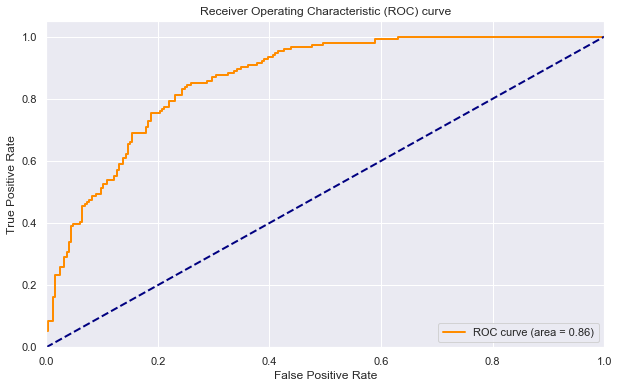

In [79]:
plot_roc(extra_trees, create_figure=True)

### Kernel Support Vector Machine model
In this last model, we consider a Support Vector Machine model to find best decision boundary hyperplane. Since we suppose our data not linearly separable, we project our data onto a infinite-dimensional space thanks to following Gaussian kernel :
$$K(\mathbf{x}, \mathbf{x'})=exp( -\lambda \lvert \lvert \mathbf{x}- \mathbf{x'} \lvert \lvert^{2}_2)
$$

In [80]:
from sklearn.svm import SVC

svc = SVC(kernel='rbf', C=1, gamma=0.1, probability=True)
svc.fit(X_train, Y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [81]:
cv_svc = grid_tuning(SVC(),
            { 'C': [0.01, 0.1, 1, 10, 100, 1000] , 'gamma': [ 1e-2, 1e-3, 1e-4] })
svc = SVC(kernel='rbf', probability=True, **cv_svc.best_params_)
svc.fit(X_train, Y_train)
models['SVM'] = compute_metrics(svc)

Best parameters : {'C': 0.1, 'gamma': 0.0001}
Metrics : {'Accuracy': 0.7325, 'F1 Score': 0.6514657980456027, 'AUC': 0.7826787034104108}


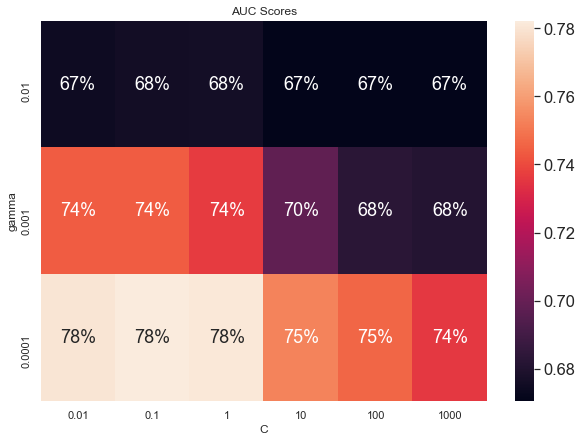

In [82]:
def plot_grid_results(cv, axis_1, axis_2):
    score_matrix = np.asarray(cv.cv_results_["mean_test_score"]).reshape((6,3))
    
    plt.figure(figsize=(10, 7))
    plt.title("AUC Scores")
    sns.set(font_scale=1.5)
    annotations = np.array([[ str("{:2.0f}%".format(x * 100))
                              for x in row ] for row in score_matrix ])
    ax = sns.heatmap(score_matrix.T, annot=annotations.T, fmt="",
               yticklabels=cv.param_grid[axis_1],
               xticklabels=cv.param_grid[axis_2])
    ax.set(ylabel=axis_1, xlabel=axis_2)

plot_grid_results(cv_svc, "gamma", "C")

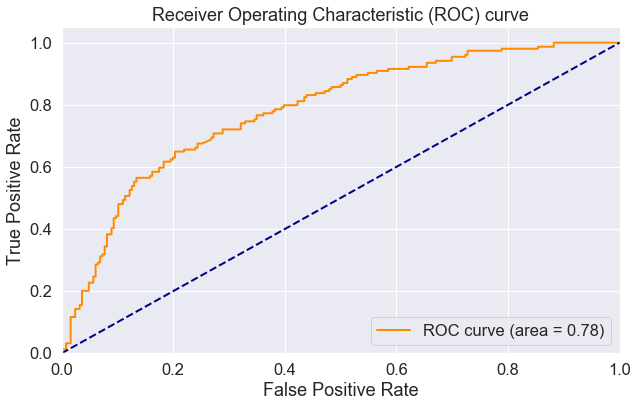

In [83]:
plot_roc(svc, create_figure=True)

### Review of models
Let us visually see which model seems to be the most powerful on our dataset.

In [84]:
results = pd.DataFrame(models).transpose()
results

,Accuracy,F1 Score,AUC
Gradient Boosting,0.8000,0.746835,0.873218
Random Forest,0.7950,0.737179,0.869470
Extra Trees,0.7825,0.707071,0.864270
SVM,0.7325,0.651466,0.782679


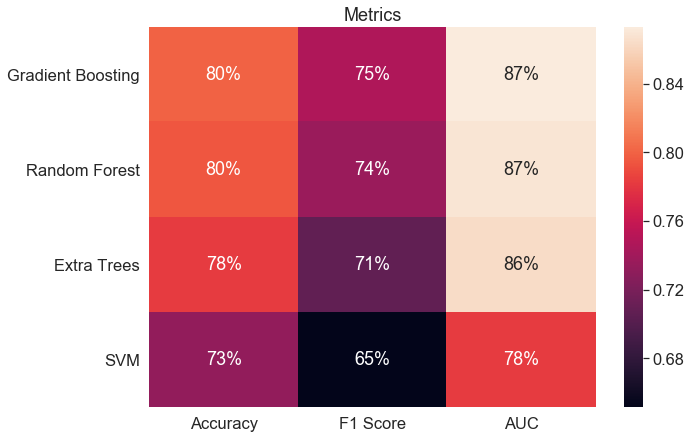

In [85]:
plt.figure(figsize=(10, 7))
plt.title("Metrics")
sns.set(font_scale=1.5)
annotations = np.array([[ str("{:2.0f}%".format(float(x) * 100))
                              for x in row ] for row in results.values ])
ax = sns.heatmap(results, annot=annotations, fmt="",
               yticklabels=results.index,
               xticklabels=results.columns)

Globally, we can see that **Gradient Boosting** obtains best scores on each metrics. However, values are very close for every tree-based methods. On the contrary, we see that Kernel SVM performs less well with every metric.

### Stability and Bootstrap methods

Accuracy metrics are computed over entire test set. Nevertheless, we are interested to evaluate model statibility, that is to say if we take a random subset of the test set, how far associated accuracy metrics will be compared to global results. In this experiment, we will compute  1000   iterations with  50%   randomly sampled train and test sets. Since it requires a lot of computation, we will deduce confidence intervals of level  95%  only for **Gradient Boosting**, but we possibly could have done the same task for three others models.

In [86]:
import warnings
# Computation time may take up to 5 minutes !
n_iter = 1000
prop_size = 0.5

metric_acc = []
metric_f1 = []
metric_auc = []

for n in range(n_iter):
    train_idx = np.random.choice(range(0, X_train.shape[0]), int(X_train.shape[0] * prop_size))  # Random indexes of train set
    test_idx = np.random.choice(range(0, X_test.shape[0]), int(X_test.shape[0] * prop_size))  # Random indexes of test set
    
    # Selecting random subsets
    sub_X_train = X_train.iloc[train_idx, :]
    sub_Y_train = Y_train.iloc[train_idx]
    sub_X_test = X_test.iloc[test_idx, :]
    sub_Y_test = Y_test.iloc[test_idx]
    
    # Computing Bootstrap models with (supposed) optimal hyper-parameters from previous cross validation
    optim_param = dict({'silent':1, 'objective':'binary:logistic', 'iter': 100, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 300})
    temp_booster = xgb.XGBClassifier(**optim_param)
    temp_booster.fit(sub_X_train, sub_Y_train)
    
    # Trick to hide Deprecation Warnings from Scikit-Learn
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        result = compute_metrics(temp_booster, x_test=sub_X_test, y_test=sub_Y_test, verbose=False)
        
    # Logging metrics into arrays
    metric_acc.append(result['Accuracy'])
    metric_f1.append(result['F1 Score'])
    metric_auc.append(result['AUC'])

[17:06:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:06:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:06:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used 

[17:06:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:06:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:06:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used 

[17:07:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:07:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:07:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used 

[17:07:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:07:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:07:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used 

[17:07:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:07:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:07:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used 

[17:07:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:07:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:07:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used 

[17:07:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:07:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:07:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used 

[17:07:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:07:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:07:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used 

[17:07:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:07:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:07:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used 

[17:07:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:07:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:07:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used 

[17:07:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:07:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:07:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used 

[17:07:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:07:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:07:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used 

[17:07:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:07:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:07:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used 

[17:07:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:07:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:07:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used 

[17:07:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:07:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:07:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used 

[17:07:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:07:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:07:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used 

[17:08:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used 

[17:08:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used 

[17:08:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used 

[17:08:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used 

[17:08:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used 

[17:08:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used 

[17:08:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used 

[17:08:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used 

[17:08:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used 

[17:08:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used 

[17:08:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used 

[17:08:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used 

[17:08:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:08:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used 

[17:09:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:09:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:09:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used 

[17:09:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:09:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:09:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used 

[17:09:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:09:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:09:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used 

[17:09:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:09:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:09:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used 

[17:09:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:09:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:09:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used 

[17:09:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:09:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:09:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used 

[17:09:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:09:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:09:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used 

[17:09:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:09:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:09:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used 

[17:09:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:09:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:09:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used 

[17:09:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:09:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:09:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used 

[17:09:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:09:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:09:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used 

[17:09:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:09:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:09:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used 

[17:10:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:10:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:10:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used 

[17:10:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:10:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:10:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { iter, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used 

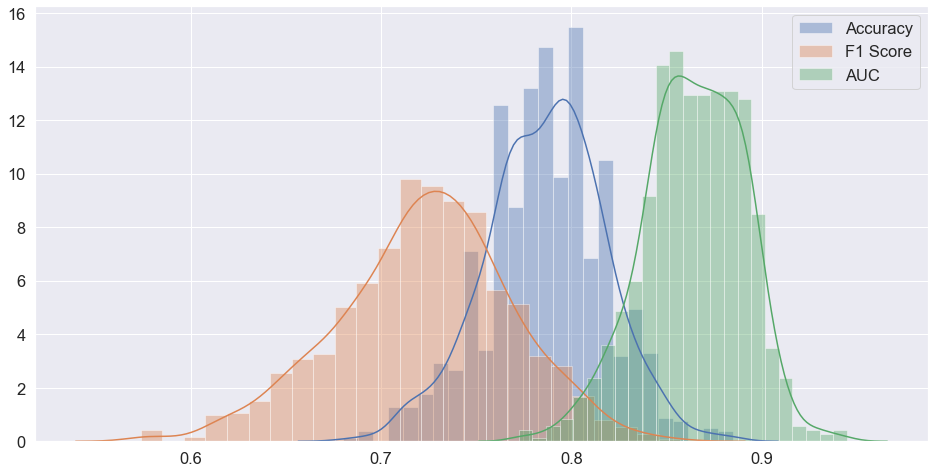

In [88]:
plt.figure(figsize=(16, 8))
sns.distplot(metric_acc, label='Accuracy')
sns.distplot(metric_f1, label="F1 Score")
sns.distplot(metric_auc, label="AUC")
plt.legend()

 ### Interpretation and explainability

Bringing response to original question is already interesting, but explaining output of our chosen model is way more satisfactory. This is why we are considering an important part in our analysis to analyze how certain features may impact more or less different outcomes.

Since a few years, new methods popped from Machine Learning research area to explain any model regardless his ground method (ensemble methods, neural network or kernel methods). These Model-Agnostic methods are independent from model itself, hence they can be used on a large majority of models. In our case, we will only use these methods on **Gradient Boosting** model, but we could easily perform the same task on Random Forests or Extra Trees.

### Partial Dependency Plots
Partial Dependency Plots (PDP), due to J. H. Friedman, shows effect over selected features on model's outcome. It enables us to see if relationship between selected features and outcome are linear, curved or complex. Suppose that we select features  I against features  J (where  |I|+|J|=p, number of features and  I∩J=∅), then partial dependence function is defined as :
$$\widehat{f}_I=\mathbb{E}_{\mathbf{X}_J} [\widehat{f}(\mathbf{x}_I, \mathbf{x}_J)]=  \int_{}^{} \widehat{f}(\mathbf{x}_I, \mathbf{x}_J) \,d\mathbb{P} (\mathbb{x}_J)
$$
Where:
- $\mathbb{x}_I$ and  $\mathbb{x}_I$ are datasets with respectively only features from  I and features from  J
- $\widehat{f}$is the empirical model
From computational aspect, we compute empirical partial dependence function with Monte Carlo methods :
$$\widehat{f}_I=\frac{1}{n} \sum_{i=1}^{n}[\widehat{f}(\mathbf{x}_I, \mathbf{x}^i_J)]
$$
Where  $\mathbf{x}^i_J$  is the  i -th observation from dataset that only contains features from  J

However, major inconvenient of PDPs is that we make assumption of independence between features, which is often not completely realized on real-worl datasets. There exists an interesting package in Python named $\href{https://github.com/SauceCat/PDPbox}{PDPbox}$   that we will use to plot PDPs.
For example, we could suppose that relationship between CallDuration and outcomes is linear increasing : the more a person stick to the phone, the more likely he is to subscribe to a car insurance.


In [89]:
#pip install pdpbox

In [90]:
from pdpbox import pdp, info_plots

(0, 1)

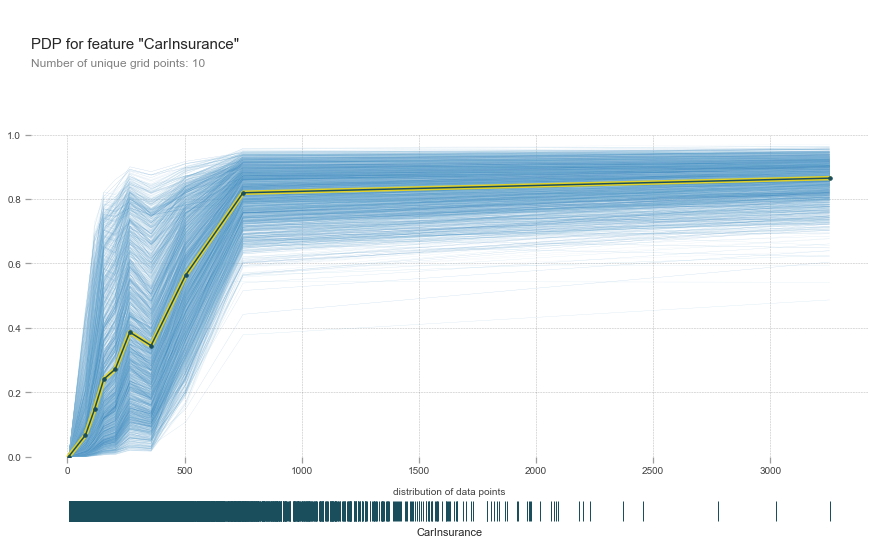

In [91]:
pdp_callduration = pdp.pdp_isolate(
    model=booster, dataset=processed_dataset[0], model_features=processed_dataset[0].columns, feature='CallDuration'
)
fig, axes = pdp.pdp_plot(pdp_callduration, 'CarInsurance', plot_lines=True, frac_to_plot=0.5, plot_pts_dist=True)
axes['pdp_ax']['_pdp_ax'].set_ylim(0, 1)

Let us explain this PDP. From  0 to approximatively  700 seconds (around  11  minutes), we can see that relationship between call duration and outcome is increasing linear, with a little drop around  250 seconds. From  700 seconds, the relationship tends to become linear and person is likely to subscribe to a car insurance. Now we study effect of balance

(-1, 1)

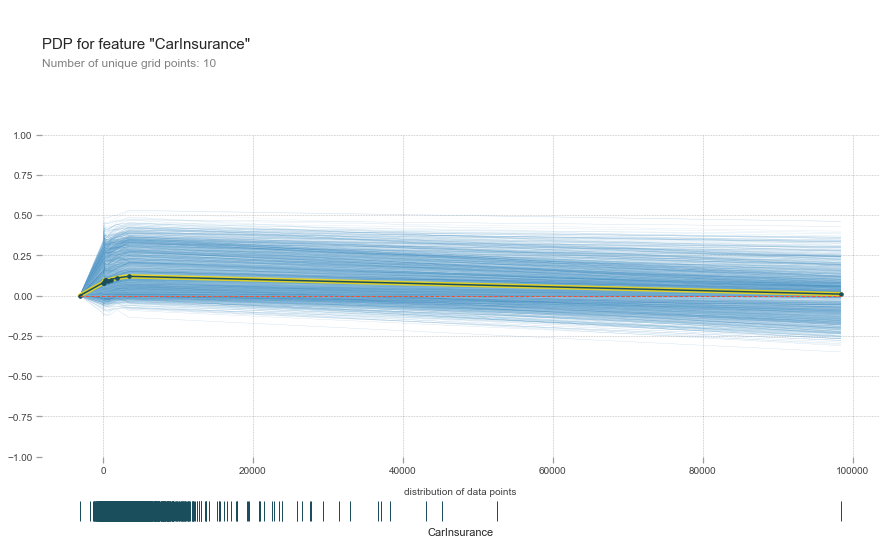

In [92]:
pdp_balance = pdp.pdp_isolate(
    model=booster, dataset=processed_dataset[0], model_features=processed_dataset[0].columns, feature='Balance'
)
fig, axes = pdp.pdp_plot(pdp_balance, 'CarInsurance', plot_lines=True, frac_to_plot=0.5, plot_pts_dist=True)
axes['pdp_ax']['_pdp_ax'].set_ylim(-1, 1)

In this case, we have a constant volatility distributed over balance. However, we can see a large majority of observations below  15000 balance. 

The relationship here is monotonous, and although a brief peak is visible on low values, this could tell us that balance has importance on outcome, but is probably not a decisive factor.
From here, we only studied dependence over one feature, but we might also want to show how two features (potentially correlated) accordingly impact outcomes. For this task, we will remove extreme values that has a balance over  50000.

In [93]:
processed_dataset[0]['Balance'] = pd.to_numeric(processed_dataset[0]['Balance'], errors='coerce')
df = processed_dataset[0]
processed_dataset_no_extreme = df.drop(df[df['Balance'] > 50000].index)
processed_dataset_no_extreme['CarInsurance'] = processed_dataset[1].drop(df[df['Balance'] > 50000].index)

TypeError: clabel() got an unexpected keyword argument 'contour_label_fontsize'

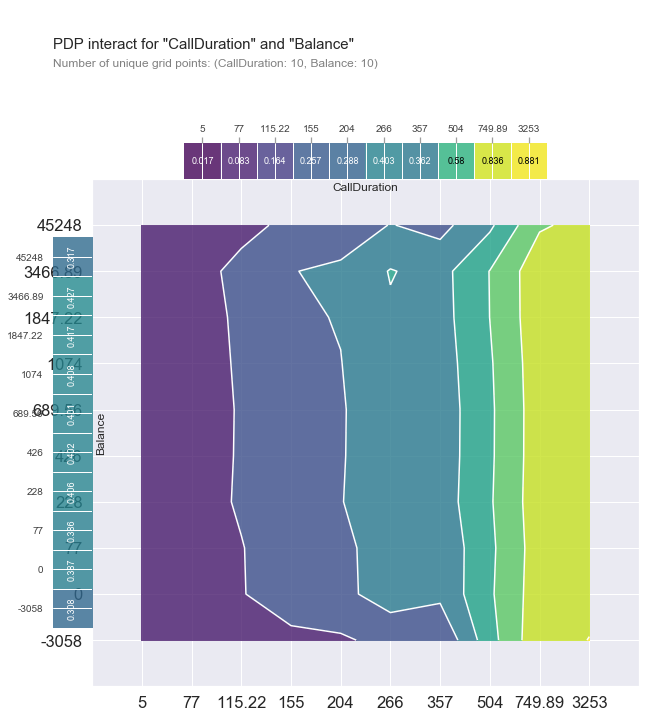

In [94]:
inter_call_balance = pdp.pdp_interact(
    model=booster, dataset=processed_dataset_no_extreme, model_features=processed_dataset[0].columns, features=['CallDuration', 'Balance']
)
fig, axes = pdp.pdp_interact_plot(pdp_interact_out=inter_call_balance, feature_names=['CallDuration', 'Balance'], plot_type='contour', x_quantile=True, plot_pdp=True
                                 )

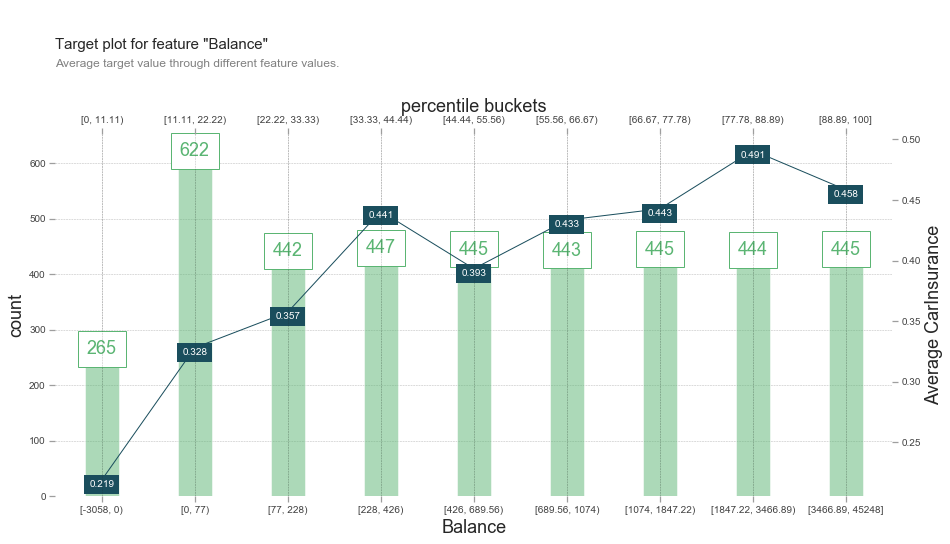

In [95]:
fig, axes, summary_df = info_plots.target_plot(
    df=processed_dataset_no_extreme, feature='Balance', feature_name='Balance', target='CarInsurance', show_percentile=True
)

It is also possible, for a more convenient visualization, aggregate features over non-proportional bins see impact of feature, as shown above for Balance feature.

### SHAP : SHapley Additive exPlanations
SHAP lies on Shapley values to understand how a feature can impact outcomes. It comes from cooperative game theory's Shapley coefficients, introduced by Shapley around 1950. For each feature of index  j
 , a computed value  ϕj
 , named contribution, gives precious sights on how this feature interacts not only on outcomes, but also paired with another set of features.

In [96]:
#pip install shap

In [97]:
import shap

First, we compute contributions for each observation in our dataset, which can require a little amount of time, although current implementation of SHAP is highly optimized for XGBoost library.

In [98]:
shap.initjs()
explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(X_test, approximate=True)
index = 359
shap.force_plot(explainer.expected_value, shap_values[index,:], X_test.iloc[index,:])

In [99]:
shap.force_plot(explainer.expected_value, shap_values, X_train)

Another interesting featre, which is not taken into account on PDP for instance, is the dependence plot of SHAP values, which enables us to study dependency with the most correlated variable.

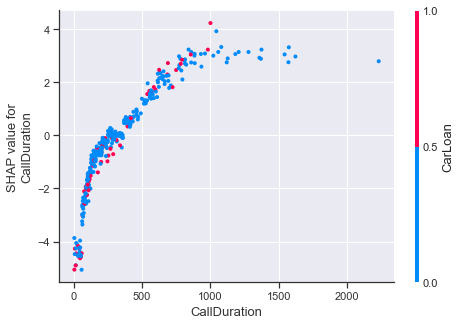

In [100]:
shap.dependence_plot("CallDuration", shap_values, X_test)

In this plot, we show SHAP values according to CallDuration. The effect of LastContactDay is shown with color palette. As far as we see, the day of last contact does not impact SHAP values when we are interested in studying CallDuration.

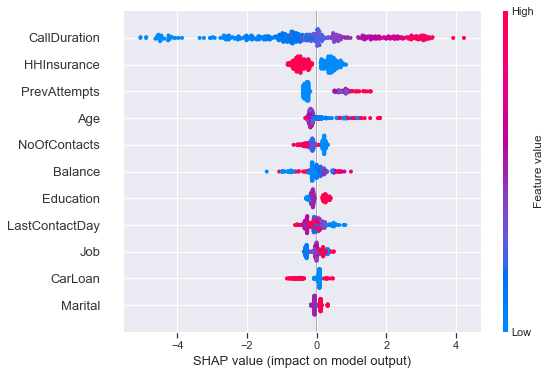

In [101]:
shap.summary_plot(shap_values, X_test)

SHAP values can be plotted for every feature as above. Each point refers to an observation (ranged alon Y-axis when there a a high density of points), and color feature value according to its own distribution ( 1
  is a high value on a categorical binary variable, while  1000
  might be considered as a high value for continuous variable). Finally, we can aggregate all this data into the following plot, which is linked with the previous one, as bar's length is the mean of absolute SHAP values, meaning global contribution of this feature is important.

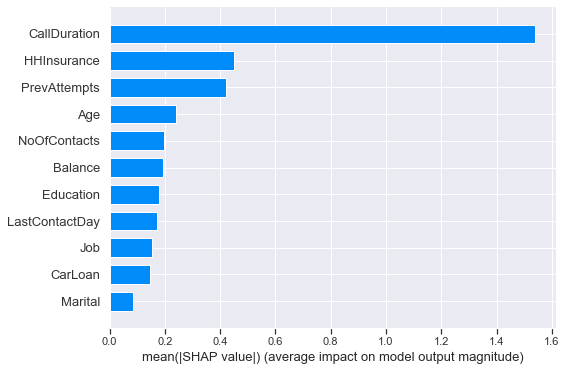

In [102]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

We could also have used ALE (Accumulated Local Effects) plots to interpret model with this new technique developed in 2016, but there are actually poor implementations in Python of this, and only ALEPlot package from R is actually reliable.

## Conclusion
This study helped us to detect most important factor that could influence in phone's successful calls. For insurance sector, this has several insights that phone's users might follow :
- It is important to make call longer, as potential subscriber could be interested.
- Share information betwenn household and car insurance, since there are obvious relationship between subscribing status.
- Focus calls towards people older than  40
  years old as descriptive statistics shows, in average, more successful outcomes on this category.
- Adapt cheaper premium for low income groups that are less susceptible to subscribe.
Note that CallDuration might contains too much information regarding successfulness of campaign, and another study where we could predict call duration or simply eliminate this feature would add more knowledge on the current situation.